# Gaussian Process Visualisation

This notebook is for creating a gif to show how adding more data points constrains the GP and improves the modelling & predictions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import imageio

## Creating our fake data

In [2]:
n = 40
m = 50
length = 501

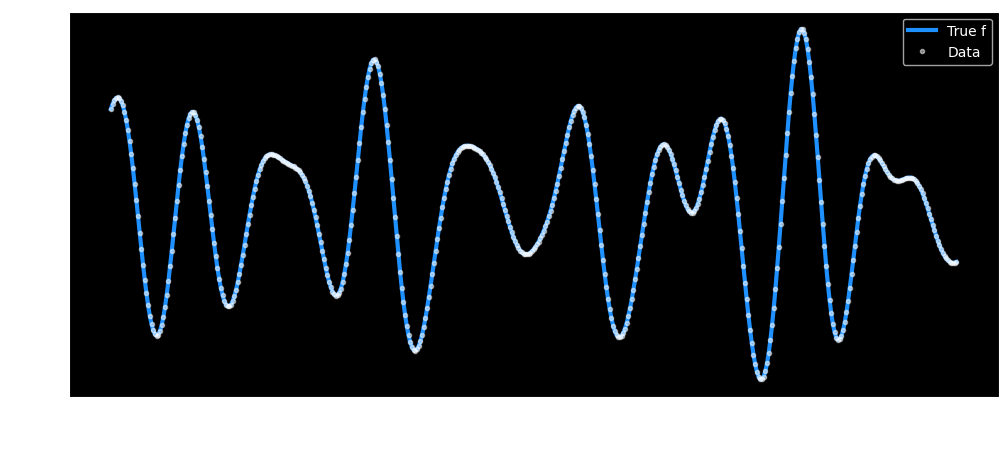

In [3]:
# set the seed
np.random.seed(1)
y = []
X = np.linspace(0, m, length)[:, None]

# Define the true covariance function and its parameters
ℓ_true1 = 3.0
ℓ_true2 = 5.0
η_true = 10.0
cov_func = η_true ** 2 * pm.gp.cov.ExpQuad(1, ℓ_true1) * pm.gp.cov.Cosine(1, ℓ_true2)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(length), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = .0
y.append(f_true + σ_true * np.random.randn(length))

# Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
plt.style.use('dark_background')
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, np.array(y).T, "ow", ms=3, alpha=0.5, label="Data", zorder=99)
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
#ax.set_title('')
plt.legend();

## Preprocessing Data

In [4]:
points = []
for i in range(1, n+2):
    points.append(np.arange(0, i))

args = []
for i in range(1, (n)*10, 10):
    args.append(np.arange(0, i, 10))
    

In [5]:
y_values = []

for index_list in args:
    temp_list = []
    for i in index_list:
        temp_list.append(y[0][i])
    y_values.append(temp_list)

## Creating the GIF

In [ ]:
frames = []
for i in range(len(points)):

    with pm.Model() as model:
        X_1 = np.array(points[i])[:,None]
        l1 = pm.Normal('l1',ℓ_true1 ,.1)
        l2 = pm.Normal('l2',ℓ_true2,.1)
        η = pm.Normal('n', η_true,0.1)

        cov = η ** 2 * pm.gp.cov.ExpQuad(1, l1) * pm.gp.cov.Cosine(1,l2) # predefined covariance function
        gp = pm.gp.Marginal(cov_func=cov) # implementation of the sum of a GP prior and noise

        σ = pm.Normal("σ", σ_true, 0.1)
        y_ = gp.marginal_likelihood("y", X=X_1, y=np.array(y_values[i]), noise=σ)

        #mp = pm.find_MAP() # finds local maximimum 'a posteriori point' given a model
        tr = pm.sample(return_inferencedata=True)
    
    X_new = np.linspace(0, m, length)[:, None]
    # add the GP conditional to the model, given the new X values
    with model:
        f_pred = gp.conditional("f_pred", X_new)

    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    with model:
        pred_samples = pm.sample_posterior_predictive(tr, var_names=['f_pred'], samples=500)
        
    # plot the results
    fig = plt.figure(figsize=(12, 5))
    plt.style.use('dark_background')
    plt.title(f"Prediction with {i+1} data points")
    ax = fig.gca()

    # plot the samples from the gp posterior with samples and shading
    from pymc3.gp.util import plot_gp_dist

    plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette="inferno")

    # plot the data and the true latent function
    #plt.plot(X, f_true, "cyan", lw=2.5, label="True Function", alpha=0.5)
    plt.plot(X_1, y_values[i], "o", color='red', ms=6, alpha=1, label="Training Data", zorder=99)
    # axis labels and title
    plt.xlabel("X")
    plt.ylabel('y')
    plt.xlim(0,m)
    plt.ylim([-30, 30])
    #plt.legend(loc="Lower right")
    
    plt.savefig(f'../Figures/img_{i}.png', 
                transparent = False,  
                facecolor = 'black'
               )
    image = imageio.v2.imread(f'../Figures/img_{i}.png')
    frames.append(image);

In [ ]:
imageio.mimsave('../Figures/GP.gif', # output gif
                frames,          # array of input frames
                fps = 2)

## Final Frame

In [6]:
frames = []


with pm.Model() as model:
    X_1 = np.array(points[39])[:,None]
    l1 = pm.Normal('l1',ℓ_true1 ,.1)
    l2 = pm.Normal('l2',ℓ_true2,.1)
    η = pm.Normal('n', η_true,0.1)

    cov = η ** 2 * pm.gp.cov.ExpQuad(1, l1) * pm.gp.cov.Cosine(1,l2) # predefined covariance function
    gp = pm.gp.Marginal(cov_func=cov) # implementation of the sum of a GP prior and noise

    σ = pm.Normal("σ", σ_true, 0.1)
    y_ = gp.marginal_likelihood("y", X=X_1, y=np.array(y_values[39]), noise=σ)

    #mp = pm.find_MAP() # finds local maximimum 'a posteriori point' given a model
    tr = pm.sample(return_inferencedata=True)

X_new = np.linspace(0, m, length)[:, None]
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive(tr, var_names=['f_pred'], samples=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, n, l2, l1]


/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represente

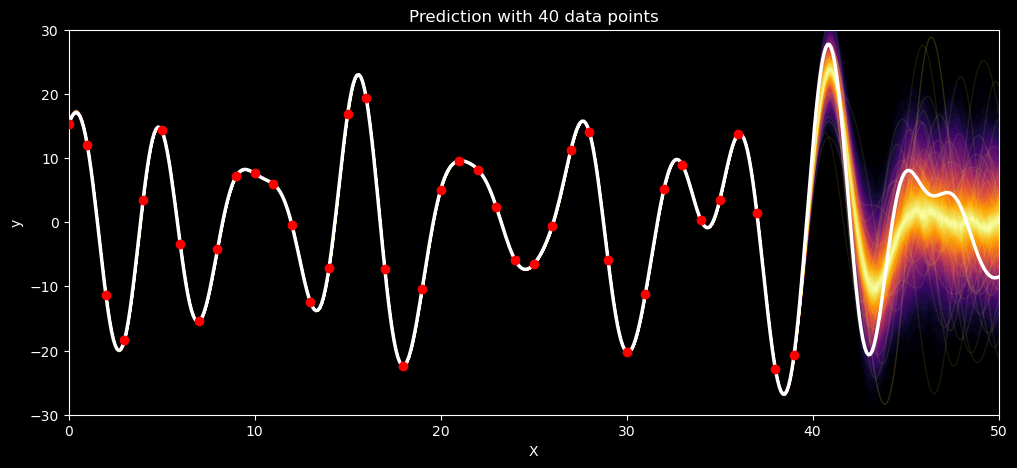

In [7]:
# plot the results
fig = plt.figure(figsize=(12, 5))
plt.style.use('dark_background')
plt.title(f"Prediction with {40} data points")
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette="inferno")

# plot the data and the true latent function
plt.plot(X, f_true, "white", lw=2.5, label="True Function", alpha=1)
plt.plot(X_1, y_values[39], "o", color='red', ms=6, alpha=1, label="Training Data", zorder=99)
# axis labels and title
plt.xlabel("X")
plt.ylabel('y')
plt.xlim(0,m)
plt.ylim([-30, 30])
#plt.legend(loc="Lower right")

'''
plt.savefig(f'../Figures/final_img.png', 
            transparent = False,  
            facecolor = 'black'
           )
'''

## Visualising the Covariance Function

In [8]:
import matplotlib.cm as cmap
np.random.seed(206)
import theano
import theano.tensor as tt

length = 500
X_new = np.linspace(0,50,length)[:,None]

# function to display covariance matrices
def plot_cov(X, K, stationary=True):
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121)
    m = ax1.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Covariance Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(122)
    if not stationary:
        ax2.plot(x, np.diag(K), "w", lw=2, alpha=0.8)
        ax2.set_title("The Diagonal of K")
        ax2.set_ylabel("k(x,x)")
    else:
        ax2.plot(x, K[:,0], "w", lw=2, alpha=0.8)
        ax2.set_title("K as a function of x - x'")
        ax2.set_ylabel("k(x,x')")
    ax2.set_xlabel("X")

    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(111)
    samples = np.random.multivariate_normal(np.zeros(length), K, 5).T;
    for i in range(samples.shape[1]):
        ax.plot(x, samples[:,i], lw=2);
    ax.set_title("Samples from GP Prior")
    ax.set_xlabel("X")

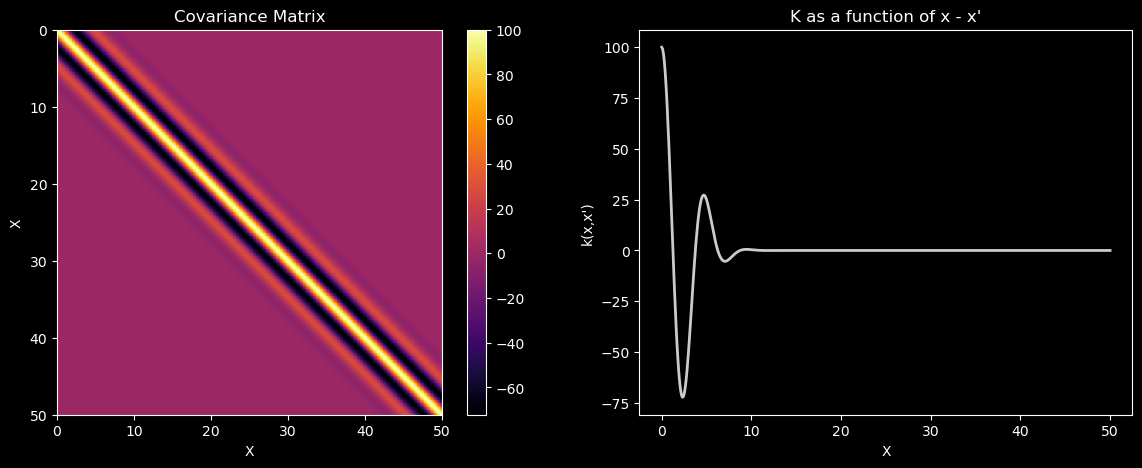

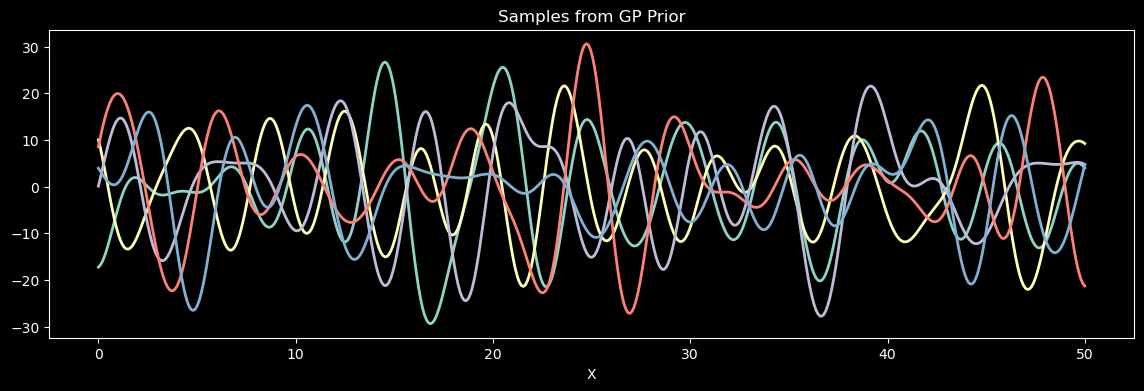

In [9]:
with pm.Model() as model:
    ℓ_true1 = 3.0
    ℓ_true2 = 5.0
    η_true = 10.0
    cov = η_true ** 2 * pm.gp.cov.ExpQuad(1, ℓ_true1) * pm.gp.cov.Cosine(1, ℓ_true2)
    
K = theano.function([], cov(X_new))()
plot_cov(X_new, K)